Import Libraries

In [3]:
#data Handling
import pandas as pd
import numpy as np

#visulization
import matplotlib.pyplot as plt
import seaborn as sns

#NLP
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Misc
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK assets
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Load Dataset

In [4]:
df = pd.read_csv("/content/fake_job_postings.csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Basis info and Null checks

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

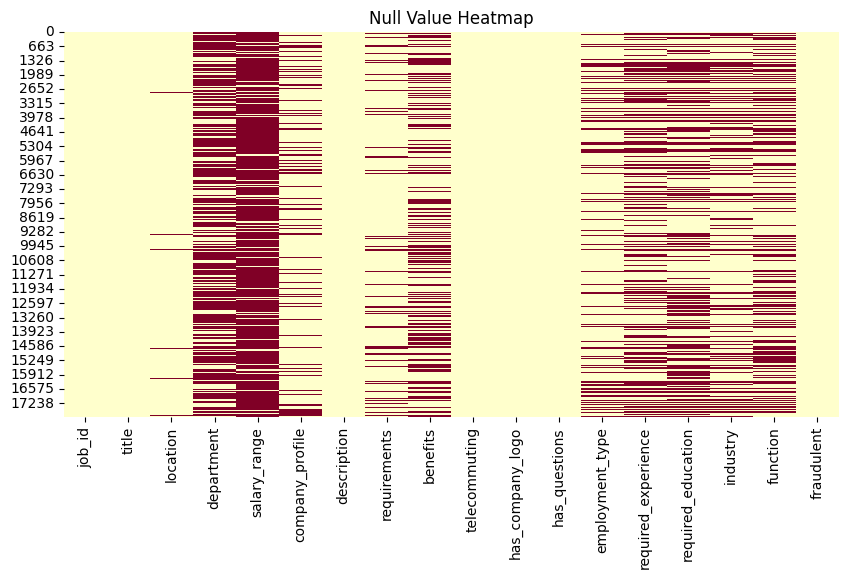

In [5]:
#basic info
df.info()
df.describe(include='object')

#null value heatmap
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False, cmap="YlOrRd")
plt.title("Null Value Heatmap")
plt.show()

In [6]:
#drop column with too many missing values or irrelevent info
df.drop(['location', 'salary_range', 'company_profile', 'telecommuting', 'has_company_logo', 'has_questions'],axis=1, inplace=True)

Target class Distribution

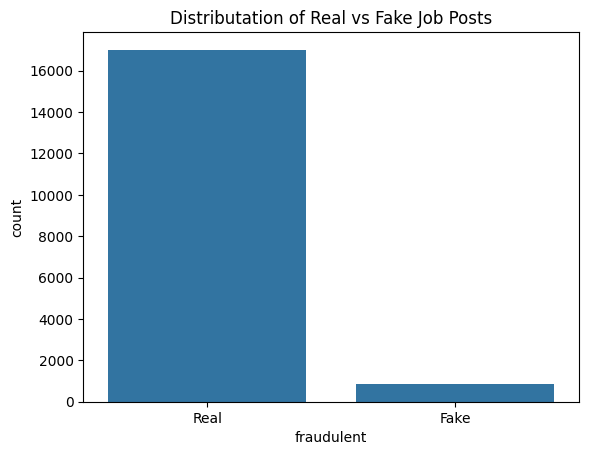

,proportion
fraudulent,
0,0.951566
1,0.048434


In [7]:
#check class balance
sns.countplot(x='fraudulent', data=df)
plt.title("Distributation of Real vs Fake Job Posts")
plt.xticks([0,1], ['Real', 'Fake'])
plt.show()

df['fraudulent'].value_counts(normalize=True)

Combine Text Columns for NLP

In [8]:
#combine relevient text fields
df['text'] = df['title'].fillna('') + ' ' + \
             df['department'].fillna('') + ' ' + \
             df['description'].fillna('') + ' ' + \
             df['requirements'].fillna('') + ' ' + \
             df['benefits'].fillna('')

df = df[['text', 'fraudulent']]
df.head(2)

,text,fraudulent
0,"Marketing Intern Marketing Food52, a fast-grow...",0
1,Customer Service - Cloud Video Production Succ...,0


Text cleaning Function

In [9]:
#define clean text function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
  #lowercase
  text = text.lower()

  #Remove HTML, special chars
  text = re.sub(r'<.*?>', '',text)
  text = re.sub(r'[%s]' % re.escape(string.punctuation), '',text)
  text = re.sub(r'\d+', '',text)
  #tokenize and lemmatize
  words = nltk.word_tokenize(text)
  words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
  return ' '.join(words)

#Apply
df['clean_text'] = df['text'].apply(clean_text)
df[['clean_text', 'fraudulent']].sample(3)

,clean_text,fraudulent
14350,customer service advisor based central harroga...,0
7354,account manager customer service representativ...,0
10907,english teacher abroad play kid get paid love ...,0


WorCloud

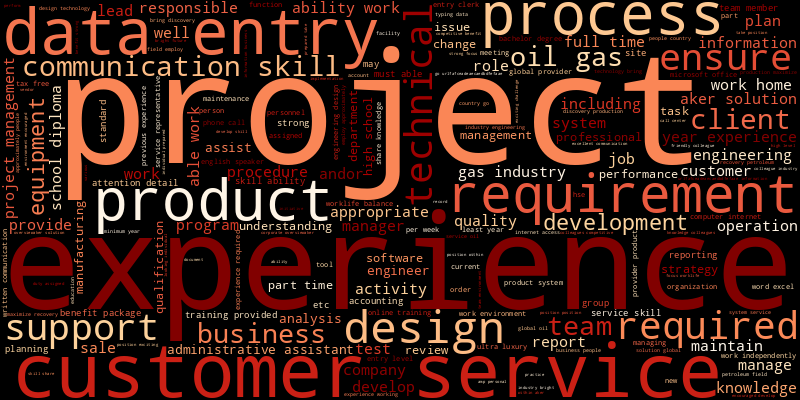

In [10]:
from wordcloud import WordCloud

#Real jobs
real_text = ' '.join(df[df['fraudulent'] == 0]['clean_text'])
WordCloud(width=800, height=400).generate(real_text).to_image()

#Fake jobs
fake_text = ' '.join(df[df['fraudulent'] == 1]['clean_text'])
WordCloud(width=800, height=400, background_color='black', colormap='OrRd').generate(fake_text).to_image()

Save Preprocessing

In [11]:
#save cleaned dataset
df[['clean_text', 'fraudulent']].to_csv("cleaned_fake_job_posting.csv", index=False)